# Sequence data prediction
**author: Zheng Liu**
<h5 style="color:purple;">Simplified problem statement (Model 1): Given a consecutive sequence of flow for time t_0 to t_k-1, predict flow at t_k.</h5>


<h5 style="color:orange;">Extended problem statement (Model 2): Given a consecutive sequence of Oi, Dj and flow for time t_0 to t_k-1, and Oi, Dj for time t_k, predict flow at t_k. (Should import (Oi,Dj) in a different way into the model)</h5>

In [297]:
import numpy as np
from sklearn.model_selection import train_test_split
import statsmodels.formula.api as smf # high-level stats
import statsmodels.api as sm
import matplotlib.pyplot as plt
import scipy
import seaborn as sns
import pandas as pd
sns.set_style("darkgrid")
%matplotlib inline
from skater.core.explanations import Interpretation
from skater.model import InMemoryModel
import shap
shap.initjs()

## Data preparation

### Simulation Data


<h5 style="color:blue;">Linear</h5>


In [3]:
np.random.rand()

0.56748225930001

(24,)

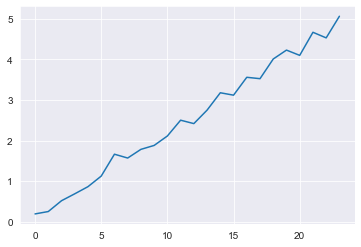

In [42]:
sequence = [0.2*x + 0.5*np.random.rand() for x in range(0, 24)]
plt.plot(sequence)
kernel = np.asarray(sequence)
kernel.shape

<h5 style="color:cyan;">Sine Wave</h5>

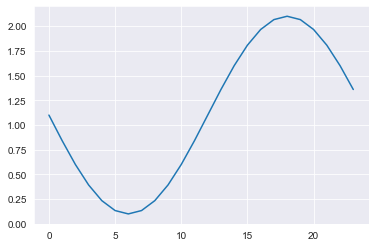

(24,)

In [334]:
from math import sin
from math import pi
# create sequence
length = 24
freq = 1
sequence = [1.1+sin(pi+2 * pi * freq * (i/length)) for i in range(length)]
# plot sequence
plt.plot(sequence)
plt.show()
kernel = np.asarray(sequence)
kernel.shape

In [335]:
# scale = np.random.rand(1000)
scale = np.random.wald(0.1,0.5,1000)
error = 0.1*np.random.rand(1000,1)
simu = scale.reshape(-1,1)*kernel + error
simu

idx = np.random.randint(len(simu), size=int(0.1*len(simu)))

simu_sample = simu[idx,:]
simu_sample.shape
df = pd.DataFrame(simu_sample)
df['obj'] = df.index
df_m = df.melt('obj',var_name='time',  value_name='vals')

(array([ 2.51934811,  8.56578356, 10.39803673,  9.39029748,  5.63417849,
         4.35160127,  2.42773545,  1.00773924,  0.7787076 ,  0.27483798,
         0.27483798,  0.09161266,  0.        ,  0.09161266]),
 array([0.02254322, 0.04437427, 0.06620531, 0.08803636, 0.1098674 ,
        0.13169844, 0.15352949, 0.17536053, 0.19719158, 0.21902262,
        0.24085366, 0.26268471, 0.28451575, 0.3063468 , 0.32817784]),
 <a list of 14 Patch objects>)

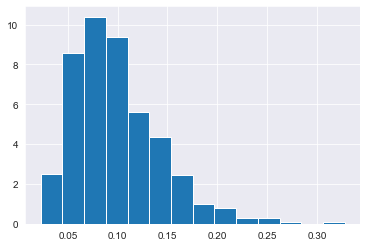

In [336]:
plt.hist(scale, 14, density=True)

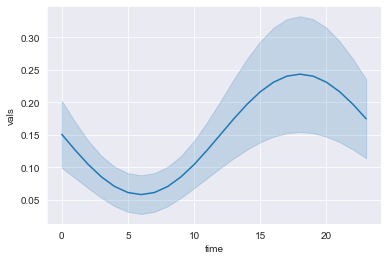

In [337]:
sns.lineplot(x="time", y="vals",ci='sd',data=df_m)

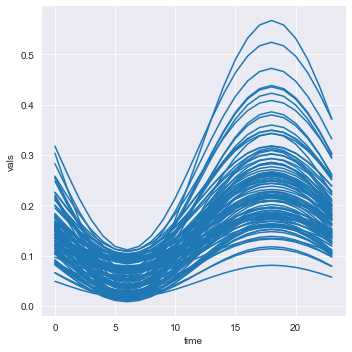

In [338]:
sns.relplot(x="time", y="vals",kind = 'line',units="obj",estimator=None,data=df_m)

In [359]:
seq = simu[:,0:23]
target = simu[:,23]


### Real world data
Use NYC taxi data.

<h5 style="color:purple;">Data for Model 1<h5>
    

In [347]:
def loadDatasetTaxiTimeSeries(hour_range):
    
    X = np.load('data/simple_taxi_X_24.npy')
    Y = np.load('data/simple_taxi_Y_24.npy')
    X_sel = X[:,0:3*hour_range]
    Y_sel = Y[:,0:hour_range]
    return (X_sel,Y_sel)

In [348]:
X, Y = loadDatasetTaxiTimeSeries(24)
Y.shape

(1000, 24)

[<matplotlib.lines.Line2D at 0x18326694c88>]

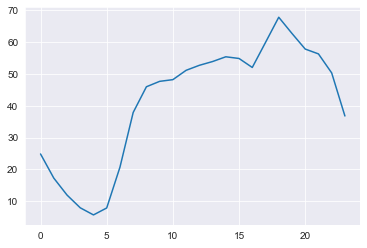

In [349]:
plt.plot(np.mean(Y,axis=0))

In [350]:
scale = 1000
idx = np.random.randint(len(Y), size=int(0.1*len(Y)))
print(idx)
Y_sample = Y[idx,:]/scale
Y_sample.shape
df = pd.DataFrame(Y_sample)
df['obj'] = df.index
df_m = df.melt('obj',var_name='time',  value_name='vals')


[672 755 351 689 849 468 280 705 702 109 491 988 122 205  67 404 256 138
 259 559 394 912 461 520 904 496 917 184 510 761 558 735 843 525 169 690
 556  80 883 696 548 982 918 857 232 199 946  22  71 935 904 708 329 206
 746 576 488 764 729 780 494 190 402 773 106  99 816 652 974 447 789 216
 360 668 831 184 587 186 277 534 966 977  36 772 211 443 358 377 514 512
 999 708 536 393 411 269 582 536  32 606]


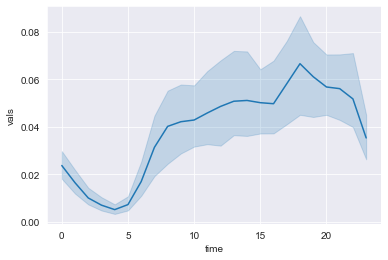

In [351]:
sns.lineplot(x="time", y="vals",ci=100,data=df_m)

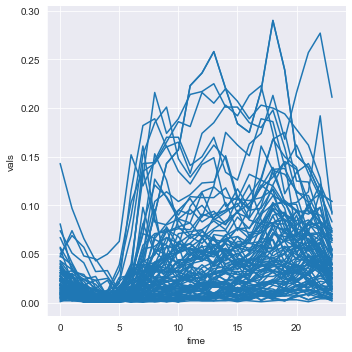

In [352]:
sns.relplot(x="time", y="vals",kind = 'line',units="obj",estimator=None,data=df_m)

In [353]:
seq = Y[:,0:23]/scale
target = Y[:,23]/scale
seq

array([[0.019, 0.022, 0.023, ..., 0.016, 0.019, 0.016],
       [0.007, 0.004, 0.007, ..., 0.008, 0.008, 0.009],
       [0.008, 0.002, 0.003, ..., 0.004, 0.006, 0.002],
       ...,
       [0.004, 0.001, 0.001, ..., 0.01 , 0.015, 0.007],
       [0.019, 0.016, 0.006, ..., 0.068, 0.067, 0.053],
       [0.001, 0.006, 0.003, ..., 0.01 , 0.013, 0.009]])

<h5 style="color:orange;">Data for Model 2

**Under development**


<h3 style="color:purple;">Load Data for Experiments

In [360]:
X_train, X_test, y_train, y_test = train_test_split(seq, target, test_size=0.2, random_state=42)

## Compare results -- Time series data

### AR model

In [64]:
# AR example
from statsmodels.tsa.ar_model import AR
from random import random
# contrived dataset
data = [x + random() for x in range(1, 100)]
# fit model
print(data)
model = AR(data)
model_fit = model.fit()
# make prediction
yhat = model_fit.predict(len(data), len(data))
print(yhat)

[1.2719442549289464, 2.784512863270899, 3.120774652656592, 4.552013710268508, 5.423887448369385, 6.480196067089158, 7.5199033797591825, 8.038499879979165, 9.333892047649103, 10.098706417953686, 11.043060245554475, 12.557575149574223, 13.47591138011841, 14.488480397433543, 15.284230871421217, 16.160239396642574, 17.9604098018969, 18.132422636299978, 19.910112385342707, 20.216335934429985, 21.58695383676108, 22.578818710593342, 23.881060175665944, 24.213421867367853, 25.326207905431993, 26.193904463755153, 27.94893660286472, 28.572090271337622, 29.830436231291515, 30.439851827904395, 31.870348754225716, 32.948470780886126, 33.49406066252696, 34.71989230116108, 35.920523987049904, 36.37002814162321, 37.01853045477452, 38.07760387401171, 39.754871750667704, 40.09536825015858, 41.81289530934962, 42.382788257073045, 43.498937117506514, 44.8804219991901, 45.673976900902076, 46.516001574034476, 47.33170679263719, 48.07466182193696, 49.01066111762036, 50.484679382851674, 51.99619518048841, 52.8

### Simple OLS Regression model
<h5 style="color:purple;">for Model 1

In [329]:
def OLSregression(X_train,y_train,X_test,y_test):
    X_train_1 = sm.add_constant(X_train)
    X_test_1 = sm.add_constant(X_test)

    model = sm.OLS(y_train,X_train_1)
    results = model.fit()
    print(results.summary())
    y_pred = np.exp(results.predict(X_test_1))
    pear = scipy.stats.pearsonr(y_test, y_pred)
    print('Pearson\'s r is {:6f}'.format(pear[0]))
    mse = np.mean((y_test - y_pred)**2)
    print('MSE is {:6f}'.format(mse))

    df = pd.DataFrame({'X_Axis': X_test[:, 1], 'y_test': y_test, 'y_pred':y_pred})
    df_m = df.melt('X_Axis', var_name='cols',  value_name='vals')
    plt.figure(figsize=(16, 10))
    ax = sns.scatterplot(x="y_test", y="y_pred", data=df)
    X_plot = np.linspace(0,np.max(y_test),400)
    plt.plot(X_plot,X_plot,'r--')
    return results
    

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 1.224e+32
Date:                Sun, 15 Dec 2019   Prob (F-statistic):               0.00
Time:                        23:49:08   Log-Likelihood:                 28226.
No. Observations:                 800   AIC:                        -5.645e+04
Df Residuals:                     797   BIC:                        -5.643e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        1.18e-16   1.26e-17      9.359      0.0

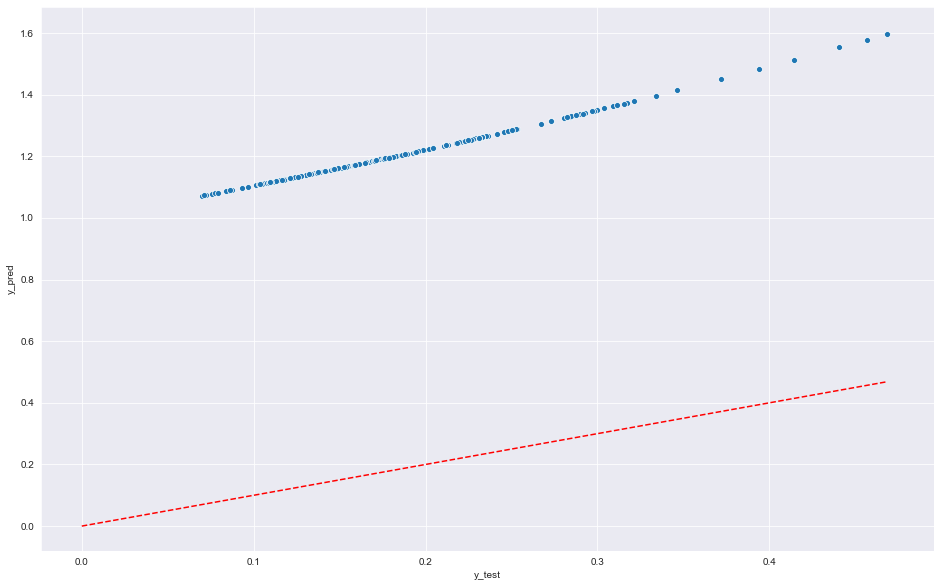

In [361]:
olsresults = OLSregression(X_train,y_train,X_test,y_test)

In [331]:
feature_names = ['const']
for i in range(23):
    feature_names.append('t_{}'.format(i))
feature_names

['const',
 't_0',
 't_1',
 't_2',
 't_3',
 't_4',
 't_5',
 't_6',
 't_7',
 't_8',
 't_9',
 't_10',
 't_11',
 't_12',
 't_13',
 't_14',
 't_15',
 't_16',
 't_17',
 't_18',
 't_19',
 't_20',
 't_21',
 't_22']

[24/24] features ████████████████████ Time elapsed: 0 seconds

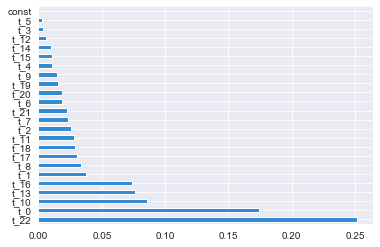

In [332]:
X_train_1 = sm.add_constant(X_train)
X_test_1 = sm.add_constant(X_test)
im_model = InMemoryModel(olsresults.predict, examples=X_train_1 
                         )
feature_names = feature_names
interpreter = Interpretation(X_test_1,
                             feature_names=feature_names)
plots = interpreter.feature_importance.plot_feature_importance(im_model)

Using 800 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_

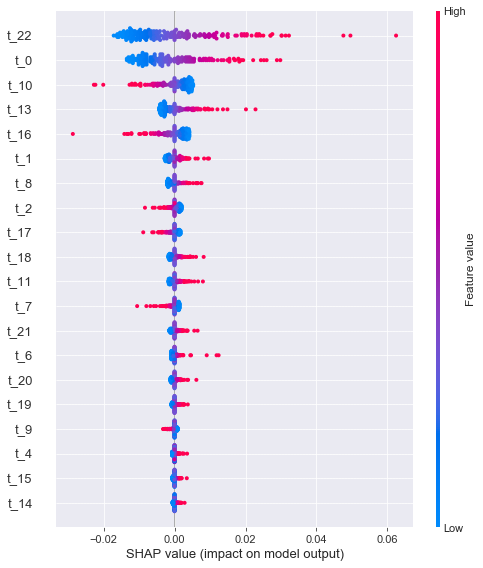

In [333]:
explainer = shap.KernelExplainer(olsresults.predict,X_train_1)
shap_values = explainer.shap_values(X_test_1)
shap.summary_plot(shap_values, features=X_test_1,  feature_names=feature_names)

In [ ]:
i = 42
shap.force_plot(explainer.expected_value, 
                shap_values[i], features=X_train_1[i], 
                feature_names=feature_names)

### Simple NN SI model
<h5 style="color:purple;">for Model 1

In [311]:
#activation functions and their gradient functions
def sigmoid(X):
    return 1/(1+np.exp(-X))

def sigmoid_grad(X):
    return sigmoid(X) * (1 - sigmoid(X))

def tanh(z):
    return np.tanh(z)

def tanh_grad(z):
     return 1 - np.tanh(z) ** 2

def ReLU(z):
    return np.clip(z, 0, np.inf)

def ReLU_grad(z):
    return (z > 0).astype(int)

def affine(X,slope=1,intercept=0):
     return slope * X + intercept
    
def affine_grad(X,slope=1,intercept=0):
    return slope * np.ones_like(X)


class NeuralNetwork:
    def __init__(self, input_dim, output_dim=1,hidden_dim = 4,lr=0.005,
                 act1 = sigmoid,
                 act2 = affine,
                 grad1 = sigmoid_grad,
                 grad2 = affine_grad):
        #init weights
        self.weights1   = np.random.rand(input_dim+1,hidden_dim) 
        self.weights2   = np.random.rand(hidden_dim,output_dim)                 
        #set learning rate
        self.lr         = lr
        self.activation1 = act1
        self.activation2 = act2
        self.grad1 = grad1
        self.grad2 = grad2
      
    def print_w(self):
        '''print weight to inspect the current values of network'''  
        print('print_weights ------------>')
        print(self.weights1)
        print(self.weights2)
        
    def feedforward(self,X):
        X = np.hstack((X,np.ones((X.shape[0],1))))
        self.layer1 = self.activation1(np.dot(X, self.weights1))
        self.output = self.activation2(np.dot(self.layer1, self.weights2))
        return self.output
    def backprop(self,X, Y):
        X = np.hstack((X,np.ones((X.shape[0],1))))
        # application of the chain rule to find derivative of the loss function with respect to weights2 and weights1
        d_weights2 = np.dot(self.layer1.T, (2*(Y - self.output) * affine_grad(np.dot(self.layer1, self.weights2))))
        d_weights1 = np.dot(X.T,  \
                            (np.dot(2*(Y - self.output) * self.grad2(np.dot(self.layer1, self.weights2)), self.weights2.T)\
                             * self.grad1(np.dot(X, self.weights1))))

        # update the weights with the derivative (slope) of the loss function multiply learning rate
        self.weights1 += d_weights1*self.lr
        self.weights2 += d_weights2*self.lr
    
    def test(self,X):
        '''get predicted values for any input data'''
        X = np.hstack((X,np.ones((X.shape[0],1))))
        hidden_layer1 = self.activation1(np.dot(X, self.weights1))
        return self.activation2(np.dot(hidden_layer1, self.weights2))
    
    def predict(self,X):
        out = self.test(X)[:,0]
        return out
    def train(self,X,Y,epoch):
        '''train model with X and Y for num_train_iterations times'''
        #print('training  ---------------->')
        for iteration in range(epoch): 
            self.feedforward(X) 
            self.backprop(X,Y)
            #print interim MSE
#             if iteration == epoch -1 :
#                 mse = np.mean((self.output - Y)**2)
#                 print("Epoch ", iteration, "MSE: ", mse)
                


In [312]:
def NNregression(X_train, X_test, y_train, y_test,
                 hidden_layer = 4,
                 batch_size = 4,
                 epoch = 500,
                 lr=0.008
                ):

    #initialize network with fixed output dim of 1
    neural_network = NeuralNetwork(X_train.shape[1],1,hidden_dim = hidden_layer,lr=lr)

    for index in range(0,X_train.shape[0],batch_size):

        #get batch X and Y
        batch_X=X_train[index:min(index+batch_size,X_train.shape[0]),:]
        batch_Y=y_train[index:min(index+batch_size,y_train.shape[0])].reshape(-1,1)
        #train model with batch
        neural_network.train(batch_X,batch_Y,epoch)
    y_pred_train = neural_network.feedforward(X_train)[:,0]
    pear_train = scipy.stats.pearsonr(y_train, y_pred_train)

    print('Training Pearson\'s r is {:6f}'.format(pear_train[0]))

    mse_train = np.mean((y_train - y_pred_train)**2)
    print('Training MSE is {:6f}'.format(mse_train))
    
    y_pred = neural_network.feedforward(X_test)[:,0]
    pear = scipy.stats.pearsonr(y_test, y_pred)

    print('Pearson\'s r is {:6f}'.format(pear[0]))

    mse = np.mean((y_test - y_pred)**2)
    print('MSE is {:6f}'.format(mse))


    df = pd.DataFrame({'X_Axis': X_test[:, 0], 'y_test': y_test, 'y_pred':y_pred})

    df_m = df.melt('X_Axis', var_name='cols',  value_name='vals')
    plt.figure(figsize=(16, 10))
    sns.scatterplot(x="y_test", y="y_pred", data=df)
    X_plot = np.linspace(0,np.max(y_test),400)
    plt.plot(X_plot,X_plot,'r--')
    return neural_network

In [313]:
y_train.shape

(800,)

Training Pearson's r is 0.992461
Training MSE is 0.000070
Pearson's r is 0.985936
MSE is 0.000189


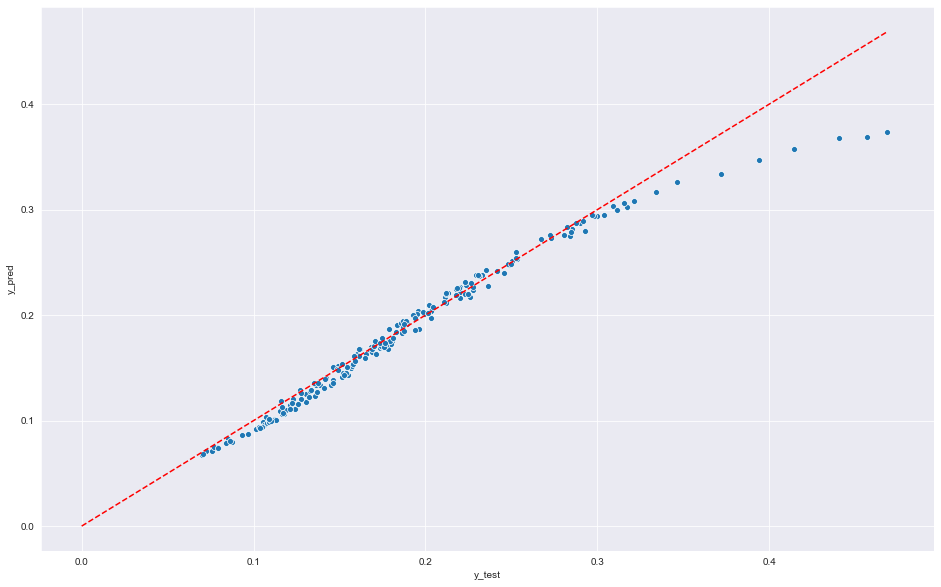

In [362]:
mlpres = NNregression(X_train, X_test, y_train, y_test,hidden_layer = 4, batch_size = 4,epoch=500,lr=0.008)

[23/23] features ████████████████████ Time elapsed: 0 seconds

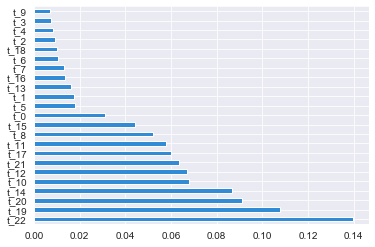

In [316]:
feature_names = []
for i in range(23):
    feature_names.append('t_{}'.format(i))
feature_names
im_model = InMemoryModel(mlpres.predict, examples=X_train 
                         )
interpreter = Interpretation(X_test,
                             feature_names=feature_names)
plots = interpreter.feature_importance.plot_feature_importance(im_model)

In [319]:
explainer = shap.KernelExplainer(mlpres.predict,X_train)
shap_values = explainer.shap_values(X_test)

Using 800 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!


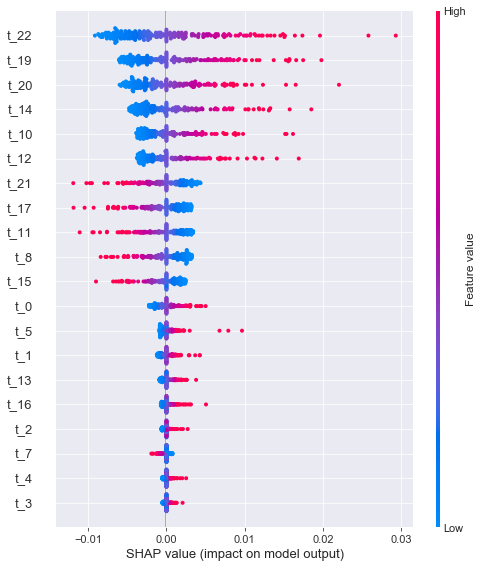

In [320]:
shap.summary_plot(shap_values, features=X_test,  feature_names=feature_names)

In [321]:
i = 42
shap.force_plot(explainer.expected_value, shap_values[i], features=X_train[i], feature_names=['const','Oi','Di','dij'])

### RNN SI model

use vanilla RNN architechture
<h5 style="color:purple;">for Model 1

In [125]:
class Layer(object):
    
    def __init__(self):
        self.parameters = list()
        
    def get_parameters(self):
        return self.parameters

    
class Linear(Layer):

    def __init__(self, n_inputs, n_outputs):
        super().__init__()
        W = np.random.randn(n_inputs, n_outputs) * np.sqrt(2.0/(n_inputs))
        self.weight = Tensor(W, autograd=True)
        self.bias = Tensor(np.zeros(n_outputs), autograd=True)
        
        self.parameters.append(self.weight)
        self.parameters.append(self.bias)

    def forward(self, input):
        return input.mm(self.weight)+self.bias.expand(0,len(input.data))



In [126]:
class Tensor (object):
    
    def __init__(self,data,
                 autograd=False,
                 creators=None,
                 creation_op=None,
                 id=None):
        
        self.data = np.asarray(data)
        self.autograd = autograd
        self.grad = None
        if(id is None):
            self.id = np.random.randint(0,100000)
        else:
            self.id = id
        
        self.creators = creators
        self.creation_op = creation_op
        self.children = {}
        
        if(creators is not None):
            for c in creators:
                if(self.id not in c.children):
                    c.children[self.id] = 1
                else:
                    c.children[self.id] += 1

    def all_children_grads_accounted_for(self):
        for id,cnt in self.children.items():
            if(cnt != 0):
                return False
        return True 
        
    def backward(self,grad=None, grad_origin=None):
        if(self.autograd):
 
            if(grad is None):
                grad = Tensor(np.ones_like(self.data))

            if(grad_origin is not None):
                if(self.children[grad_origin.id] == 0):
                    raise Exception("cannot backprop more than once")
                else:
                    self.children[grad_origin.id] -= 1

            if(self.grad is None):
                self.grad = grad
            else:
                self.grad += grad
            
            # grads must not have grads of their own
            assert grad.autograd == False
            
            # only continue backpropping if there's something to
            # backprop into and if all gradients (from children)
            # are accounted for override waiting for children if
            # "backprop" was called on this variable directly
            if(self.creators is not None and 
               (self.all_children_grads_accounted_for() or 
                grad_origin is None)):

                if(self.creation_op == "add"):
                    self.creators[0].backward(self.grad, self)
                    self.creators[1].backward(self.grad, self)
                    
                if(self.creation_op == "sub"):
                    self.creators[0].backward(Tensor(self.grad.data), self)
                    self.creators[1].backward(Tensor(self.grad.__neg__().data), self)

                if(self.creation_op == "mul"):
                    new = self.grad * self.creators[1]
                    self.creators[0].backward(new , self)
                    new = self.grad * self.creators[0]
                    self.creators[1].backward(new, self)                    
                    
                if(self.creation_op == "mm"):
                    c0 = self.creators[0]
                    c1 = self.creators[1]
                    new = self.grad.mm(c1.transpose())
                    c0.backward(new)
                    new = self.grad.transpose().mm(c0).transpose()
                    c1.backward(new)
                    
                if(self.creation_op == "transpose"):
                    self.creators[0].backward(self.grad.transpose())

                if("sum" in self.creation_op):
                    dim = int(self.creation_op.split("_")[1])
                    self.creators[0].backward(self.grad.expand(dim,
                                                               self.creators[0].data.shape[dim]))

                if("expand" in self.creation_op):
                    dim = int(self.creation_op.split("_")[1])
                    self.creators[0].backward(self.grad.sum(dim))
                    
                if(self.creation_op == "neg"):
                    self.creators[0].backward(self.grad.__neg__())
                    
                if(self.creation_op == "sigmoid"):
                    ones = Tensor(np.ones_like(self.grad.data))
                    self.creators[0].backward(self.grad * (self * (ones - self)))
                
                if(self.creation_op == "tanh"):
                    ones = Tensor(np.ones_like(self.grad.data))
                    self.creators[0].backward(self.grad * (ones - (self * self)))
                
                if(self.creation_op == "index_select"):
                    new_grad = np.zeros_like(self.creators[0].data)
                    indices_ = self.index_select_indices.data.flatten()
                    grad_ = grad.data.reshape(len(indices_), -1)
                    for i in range(len(indices_)):
                        new_grad[indices_[i]] += grad_[i]
                    self.creators[0].backward(Tensor(new_grad))
                    
                if(self.creation_op == "cross_entropy"):
                    dx = self.softmax_output - self.target_dist
                    self.creators[0].backward(Tensor(dx))
                    
    def __add__(self, other):
        if(self.autograd and other.autograd):
            return Tensor(self.data + other.data,
                          autograd=True,
                          creators=[self,other],
                          creation_op="add")
        return Tensor(self.data + other.data)

    def __neg__(self):
        if(self.autograd):
            return Tensor(self.data * -1,
                          autograd=True,
                          creators=[self],
                          creation_op="neg")
        return Tensor(self.data * -1)
    
    def __sub__(self, other):
        if(self.autograd and other.autograd):
            return Tensor(self.data - other.data,
                          autograd=True,
                          creators=[self,other],
                          creation_op="sub")
        return Tensor(self.data - other.data)
    
    def __mul__(self, other):
        if(self.autograd and other.autograd):
            return Tensor(self.data * other.data,
                          autograd=True,
                          creators=[self,other],
                          creation_op="mul")
        return Tensor(self.data * other.data)    

    def sum(self, dim):
        if(self.autograd):
            return Tensor(self.data.sum(dim),
                          autograd=True,
                          creators=[self],
                          creation_op="sum_"+str(dim))
        return Tensor(self.data.sum(dim))
    
    def expand(self, dim,copies):

        trans_cmd = list(range(0,len(self.data.shape)))
        trans_cmd.insert(dim,len(self.data.shape))
        new_data = self.data.repeat(copies).reshape(list(self.data.shape) + [copies]).transpose(trans_cmd)
        
        if(self.autograd):
            return Tensor(new_data,
                          autograd=True,
                          creators=[self],
                          creation_op="expand_"+str(dim))
        return Tensor(new_data)
    
    def transpose(self):
        if(self.autograd):
            return Tensor(self.data.transpose(),
                          autograd=True,
                          creators=[self],
                          creation_op="transpose")
        
        return Tensor(self.data.transpose())
    
    def mm(self, x):
        if(self.autograd):
            return Tensor(self.data.dot(x.data),
                          autograd=True,
                          creators=[self,x],
                          creation_op="mm")
        return Tensor(self.data.dot(x.data))
    
    def sigmoid(self):
        if(self.autograd):
            return Tensor(1 / (1 + np.exp(-self.data)),
                          autograd=True,
                          creators=[self],
                          creation_op="sigmoid")
        return Tensor(1 / (1 + np.exp(-self.data)))

    def tanh(self):
        if(self.autograd):
            return Tensor(np.tanh(self.data),
                          autograd=True,
                          creators=[self],
                          creation_op="tanh")
        return Tensor(np.tanh(self.data))
    
    def index_select(self, indices):

        if(self.autograd):
            new = Tensor(self.data[indices.data],
                         autograd=True,
                         creators=[self],
                         creation_op="index_select")
            new.index_select_indices = indices
            return new
        return Tensor(self.data[indices.data])
    
    def cross_entropy(self, target_indices):

        temp = np.exp(self.data)
        softmax_output = temp / np.sum(temp,
                                       axis=len(self.data.shape)-1,
                                       keepdims=True)
        
        t = target_indices.data.flatten()
        p = softmax_output.reshape(len(t),-1)
        target_dist = np.eye(p.shape[1])[t]
        loss = -(np.log(p) * (target_dist)).sum(1).mean()
    
        if(self.autograd):
            out = Tensor(loss,
                         autograd=True,
                         creators=[self],
                         creation_op="cross_entropy")
            out.softmax_output = softmax_output
            out.target_dist = target_dist
            return out

        return Tensor(loss)
        
    
    def __repr__(self):
        return str(self.data.__repr__())
    
    def __str__(self):
        return str(self.data.__str__())  
    
class Tanh(Layer):
    def __init__(self):
        super().__init__()
    
    def forward(self, input):
        return input.tanh()
    
class Sigmoid(Layer):
    def __init__(self):
        super().__init__()
    
    def forward(self, input):
        return input.sigmoid()

In [127]:
class MSELoss(Layer):
    
    def __init__(self):
        super().__init__()
    
    def forward(self, pred, target):
        return ((pred - target)*(pred - target)).sum(0)

In [128]:
class CrossEntropyLoss(object):
    
    def __init__(self):
        super().__init__()
    
    def forward(self, input, target):
        return input.cross_entropy(target)

In [129]:
class SGD(object):
    
    def __init__(self, parameters, alpha=0.1):
        self.parameters = parameters
        self.alpha = alpha
    
    def zero(self):
        for p in self.parameters:
            p.grad.data *= 0
        
    def step(self, zero=True):
        
        for p in self.parameters:
            
            p.data -= p.grad.data * self.alpha
            
            if(zero):
                p.grad.data *= 0

In [130]:
class RNNCell(Layer):
    
    def __init__(self, n_inputs, n_hidden, n_output, activation='sigmoid'):
        super().__init__()

        self.n_inputs = n_inputs
        self.n_hidden = n_hidden
        self.n_output = n_output
        
        if(activation == 'sigmoid'):
            self.activation = Sigmoid()
        elif(activation == 'tanh'):
            self.activation == Tanh()
        else:
            raise Exception("Non-linearity not found")

        self.w_ih = Linear(n_inputs, n_hidden)
        self.w_hh = Linear(n_hidden, n_hidden)
        self.w_ho = Linear(n_hidden, n_output)
        
        self.parameters += self.w_ih.get_parameters()
        self.parameters += self.w_hh.get_parameters()
        self.parameters += self.w_ho.get_parameters()        
    
    def forward(self, input, hidden):
        from_prev_hidden = self.w_hh.forward(hidden)
        combined = self.w_ih.forward(input) + from_prev_hidden
        new_hidden = self.activation.forward(combined)
        output = self.w_ho.forward(new_hidden)
        return output, new_hidden
    
    def init_hidden(self, batch_size=1):
        return Tensor(np.zeros((batch_size,self.n_hidden)), autograd=True)

In [365]:

model = RNNCell(n_inputs=1, n_hidden=16, n_output=1)

criterion = MSELoss()
optim = SGD(parameters=model.get_parameters(), alpha=0.01)

#### Training RNN

In [366]:
batch_size = 10
for index in range(0,800,batch_size):

    total_loss = 0
    
    hidden = model.init_hidden(batch_size=batch_size)
    for t in range(23):
        #print('t={}'.format(t))
        rnn_input= Tensor(X_train[index:min(index+batch_size,X_train.shape[0]),t].reshape(-1,1), autograd=True)        
        output, hidden = model.forward(input=rnn_input, hidden=hidden)
        #print(output)
    target = Tensor(y_train[index:min(index+batch_size,X_train.shape[0])].reshape(-1,1), autograd=True)    
    loss = criterion.forward(output, target)
    loss.backward()
    optim.step()
    total_loss += loss.data
    
    if(index % 100 == 0):

#         p_correct = (target.data == np.argmax(output.data,axis=1)).mean()
        pear = scipy.stats.pearsonr(target.data.ravel(),output.data.ravel())
        print("Loss:",total_loss / (len(X_train)/batch_size),"% Pearson's R:",pear[0])

Loss: [0.00157041] % Pearson's R: -0.9902851723047383
Loss: [0.00147063] % Pearson's R: -0.9692102755184322
Loss: [0.00093856] % Pearson's R: -0.28329078164432087
Loss: [0.00019425] % Pearson's R: 0.15112973501075117
Loss: [0.00023844] % Pearson's R: 0.9927206806579385
Loss: [0.0008396] % Pearson's R: 0.9822292476685032
Loss: [0.00050069] % Pearson's R: 0.9929407267542718
Loss: [0.0004843] % Pearson's R: 0.9971042694629135


#### Predict with RNN

[0.82044118]
MSE is 0.004102
Pearson's r is 0.993424


[<matplotlib.lines.Line2D at 0x1832ec91c48>]

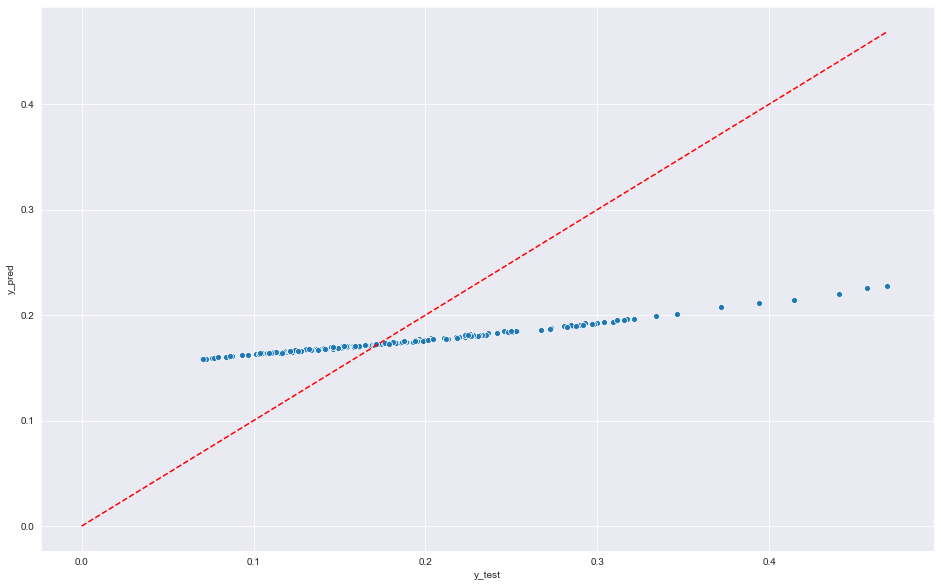

In [367]:
#testing

hidden = model.init_hidden(batch_size=200)
for t in range(23):
    #print('t={}'.format(t))
    rnn_input= Tensor(X_test[:,t].reshape(-1,1), autograd=True)        
    output, hidden = model.forward(input=rnn_input, hidden=hidden)
target = Tensor(y_test.reshape(-1,1), autograd=True)    
loss = criterion.forward(output, target)
y_test = target.data.ravel()
y_pred = output.data.ravel()
mse = np.mean((y_test - y_pred)**2)
print(loss)
print('MSE is {:6f}'.format(mse))
pear = scipy.stats.pearsonr(target.data.ravel(),output.data.ravel())
print('Pearson\'s r is {:6f}'.format(pear[0]))
df = pd.DataFrame({'X_Axis': X_test[:, 0], 'y_test': target.data.ravel(), 'y_pred':output.data.ravel()})
plt.figure(figsize=(16, 10))
sns.scatterplot(x="y_test", y="y_pred", data=df)
X_plot = np.linspace(0,np.max(y_test),400)
plt.plot(X_plot,X_plot,'r--')

### LSTM SI model
use LSTM architechture
<h5 style="color:purple;">for Model 1

In [341]:
import numpy as np

class Tensor (object):
    
    def __init__(self,data,
                 autograd=False,
                 creators=None,
                 creation_op=None,
                 id=None):
        
        self.data = np.array(data)
        self.autograd = autograd
        self.grad = None

        if(id is None):
            self.id = np.random.randint(0,1000000000)
        else:
            self.id = id
        
        self.creators = creators
        self.creation_op = creation_op
        self.children = {}
        
        if(creators is not None):
            for c in creators:
                if(self.id not in c.children):
                    c.children[self.id] = 1
                else:
                    c.children[self.id] += 1

    def all_children_grads_accounted_for(self):
        for id,cnt in self.children.items():
            if(cnt != 0):
                return False
        return True 
        
    def backward(self,grad=None, grad_origin=None):
        if(self.autograd):
 
            if(grad is None):
                grad = Tensor(np.ones_like(self.data))

            if(grad_origin is not None):
                if(self.children[grad_origin.id] == 0):
                    return
                    print(self.id)
                    print(self.creation_op)
                    print(len(self.creators))
                    for c in self.creators:
                        print(c.creation_op)
                    raise Exception("cannot backprop more than once")
                else:
                    self.children[grad_origin.id] -= 1

            if(self.grad is None):
                self.grad = grad
            else:
                self.grad += grad
            
            # grads must not have grads of their own
            assert grad.autograd == False
            
            # only continue backpropping if there's something to
            # backprop into and if all gradients (from children)
            # are accounted for override waiting for children if
            # "backprop" was called on this variable directly
            if(self.creators is not None and 
               (self.all_children_grads_accounted_for() or 
                grad_origin is None)):

                if(self.creation_op == "add"):
                    self.creators[0].backward(self.grad, self)
                    self.creators[1].backward(self.grad, self)
                    
                if(self.creation_op == "sub"):
                    self.creators[0].backward(Tensor(self.grad.data), self)
                    self.creators[1].backward(Tensor(self.grad.__neg__().data), self)

                if(self.creation_op == "mul"):
                    new = self.grad * self.creators[1]
                    self.creators[0].backward(new , self)
                    new = self.grad * self.creators[0]
                    self.creators[1].backward(new, self)                    
                    
                if(self.creation_op == "mm"):
                    c0 = self.creators[0]
                    c1 = self.creators[1]
                    new = self.grad.mm(c1.transpose())
                    c0.backward(new)
                    new = self.grad.transpose().mm(c0).transpose()
                    c1.backward(new)
                    
                if(self.creation_op == "transpose"):
                    self.creators[0].backward(self.grad.transpose())

                if("sum" in self.creation_op):
                    dim = int(self.creation_op.split("_")[1])
                    self.creators[0].backward(self.grad.expand(dim,
                                                               self.creators[0].data.shape[dim]))

                if("expand" in self.creation_op):
                    dim = int(self.creation_op.split("_")[1])
                    self.creators[0].backward(self.grad.sum(dim))
                    
                if(self.creation_op == "neg"):
                    self.creators[0].backward(self.grad.__neg__())
                    
                if(self.creation_op == "sigmoid"):
                    ones = Tensor(np.ones_like(self.grad.data))
                    self.creators[0].backward(self.grad * (self * (ones - self)))
                
                if(self.creation_op == "tanh"):
                    ones = Tensor(np.ones_like(self.grad.data))
                    self.creators[0].backward(self.grad * (ones - (self * self)))
                
                if(self.creation_op == "index_select"):
                    new_grad = np.zeros_like(self.creators[0].data)
                    indices_ = self.index_select_indices.data.flatten()
                    grad_ = grad.data.reshape(len(indices_), -1)
                    for i in range(len(indices_)):
                        new_grad[indices_[i]] += grad_[i]
                    self.creators[0].backward(Tensor(new_grad))
                    
                if(self.creation_op == "cross_entropy"):
                    dx = self.softmax_output - self.target_dist
                    self.creators[0].backward(Tensor(dx))
                    
    def __add__(self, other):
        if(self.autograd and other.autograd):
            return Tensor(self.data + other.data,
                          autograd=True,
                          creators=[self,other],
                          creation_op="add")
        return Tensor(self.data + other.data)

    def __neg__(self):
        if(self.autograd):
            return Tensor(self.data * -1,
                          autograd=True,
                          creators=[self],
                          creation_op="neg")
        return Tensor(self.data * -1)
    
    def __sub__(self, other):
        if(self.autograd and other.autograd):
            return Tensor(self.data - other.data,
                          autograd=True,
                          creators=[self,other],
                          creation_op="sub")
        return Tensor(self.data - other.data)
    
    def __mul__(self, other):
        if(self.autograd and other.autograd):
            return Tensor(self.data * other.data,
                          autograd=True,
                          creators=[self,other],
                          creation_op="mul")
        return Tensor(self.data * other.data)    

    def sum(self, dim):
        if(self.autograd):
            return Tensor(self.data.sum(dim),
                          autograd=True,
                          creators=[self],
                          creation_op="sum_"+str(dim))
        return Tensor(self.data.sum(dim))
    
    def expand(self, dim,copies):

        trans_cmd = list(range(0,len(self.data.shape)))
        trans_cmd.insert(dim,len(self.data.shape))
        new_data = self.data.repeat(copies).reshape(list(self.data.shape) + [copies]).transpose(trans_cmd)
        
        if(self.autograd):
            return Tensor(new_data,
                          autograd=True,
                          creators=[self],
                          creation_op="expand_"+str(dim))
        return Tensor(new_data)
    
    def transpose(self):
        if(self.autograd):
            return Tensor(self.data.transpose(),
                          autograd=True,
                          creators=[self],
                          creation_op="transpose")
        
        return Tensor(self.data.transpose())
    
    def mm(self, x):
        if(self.autograd):
            return Tensor(self.data.dot(x.data),
                          autograd=True,
                          creators=[self,x],
                          creation_op="mm")
        return Tensor(self.data.dot(x.data))
    
    def sigmoid(self):
        if(self.autograd):
            return Tensor(1 / (1 + np.exp(-self.data)),
                          autograd=True,
                          creators=[self],
                          creation_op="sigmoid")
        return Tensor(1 / (1 + np.exp(-self.data)))

    def tanh(self):
        if(self.autograd):
            return Tensor(np.tanh(self.data),
                          autograd=True,
                          creators=[self],
                          creation_op="tanh")
        return Tensor(np.tanh(self.data))
    
    def index_select(self, indices):

        if(self.autograd):
            new = Tensor(self.data[indices.data],
                         autograd=True,
                         creators=[self],
                         creation_op="index_select")
            new.index_select_indices = indices
            return new
        return Tensor(self.data[indices.data])
    
    def softmax(self):
        temp = np.exp(self.data)
        softmax_output = temp / np.sum(temp,
                                       axis=len(self.data.shape)-1,
                                       keepdims=True)
        return softmax_output
    
    def cross_entropy(self, target_indices):

        temp = np.exp(self.data)
        softmax_output = temp / np.sum(temp,
                                       axis=len(self.data.shape)-1,
                                       keepdims=True)
        
        t = target_indices.data.flatten()
        p = softmax_output.reshape(len(t),-1)
        target_dist = np.eye(p.shape[1])[t]
        loss = -(np.log(p) * (target_dist)).sum(1).mean()
    
        if(self.autograd):
            out = Tensor(loss,
                         autograd=True,
                         creators=[self],
                         creation_op="cross_entropy")
            out.softmax_output = softmax_output
            out.target_dist = target_dist
            return out

        return Tensor(loss)
        
    
    def __repr__(self):
        return str(self.data.__repr__())
    
    def __str__(self):
        return str(self.data.__str__())  

class Layer(object):
    
    def __init__(self):
        self.parameters = list()
        
    def get_parameters(self):
        return self.parameters

    
class SGD(object):
    
    def __init__(self, parameters, alpha=0.1):
        self.parameters = parameters
        self.alpha = alpha
    
    def zero(self):
        for p in self.parameters:
            p.grad.data *= 0
        
    def step(self, zero=True):
        
        for p in self.parameters:
            
            p.data -= p.grad.data * self.alpha
            
            if(zero):
                p.grad.data *= 0


class Linear(Layer):

    def __init__(self, n_inputs, n_outputs, bias=True):
        super().__init__()
        
        self.use_bias = bias
        
        W = np.random.randn(n_inputs, n_outputs) * np.sqrt(2.0/(n_inputs))
        self.weight = Tensor(W, autograd=True)
        if(self.use_bias):
            self.bias = Tensor(np.zeros(n_outputs), autograd=True)
        
        self.parameters.append(self.weight)
        
        if(self.use_bias):        
            self.parameters.append(self.bias)

    def forward(self, input):
        if(self.use_bias):
            return input.mm(self.weight)+self.bias.expand(0,len(input.data))
        return input.mm(self.weight)


class Sequential(Layer):
    
    def __init__(self, layers=list()):
        super().__init__()
        
        self.layers = layers
    
    def add(self, layer):
        self.layers.append(layer)
        
    def forward(self, input):
        for layer in self.layers:
            input = layer.forward(input)
        return input
    
    def get_parameters(self):
        params = list()
        for l in self.layers:
            params += l.get_parameters()
        return params


class Embedding(Layer):
    
    def __init__(self, vocab_size, dim):
        super().__init__()
        
        self.vocab_size = vocab_size
        self.dim = dim
        
        # this random initialiation style is just a convention from word2vec
        self.weight = Tensor((np.random.rand(vocab_size, dim) - 0.5) / dim, autograd=True)
        
        self.parameters.append(self.weight)
    
    def forward(self, input):
        return self.weight.index_select(input)


class Tanh(Layer):
    def __init__(self):
        super().__init__()
    
    def forward(self, input):
        return input.tanh()


class Sigmoid(Layer):
    def __init__(self):
        super().__init__()
    
    def forward(self, input):
        return input.sigmoid()
    

class CrossEntropyLoss(object):
    
    def __init__(self):
        super().__init__()
    
    def forward(self, input, target):
        return input.cross_entropy(target)

    
class RNNCell(Layer):
    
    def __init__(self, n_inputs, n_hidden, n_output, activation='sigmoid'):
        super().__init__()

        self.n_inputs = n_inputs
        self.n_hidden = n_hidden
        self.n_output = n_output
        
        if(activation == 'sigmoid'):
            self.activation = Sigmoid()
        elif(activation == 'tanh'):
            self.activation == Tanh()
        else:
            raise Exception("Non-linearity not found")

        self.w_ih = Linear(n_inputs, n_hidden)
        self.w_hh = Linear(n_hidden, n_hidden)
        self.w_ho = Linear(n_hidden, n_output)
        
        self.parameters += self.w_ih.get_parameters()
        self.parameters += self.w_hh.get_parameters()
        self.parameters += self.w_ho.get_parameters()        
    
    def forward(self, input, hidden):
        from_prev_hidden = self.w_hh.forward(hidden)
        combined = self.w_ih.forward(input) + from_prev_hidden
        new_hidden = self.activation.forward(combined)
        output = self.w_ho.forward(new_hidden)
        return output, new_hidden
    
    def init_hidden(self, batch_size=1):
        return Tensor(np.zeros((batch_size,self.n_hidden)), autograd=True)
    

In [342]:
class LSTMCell(Layer):
    
    def __init__(self, n_inputs, n_hidden, n_output):
        super().__init__()

        self.n_inputs = n_inputs
        self.n_hidden = n_hidden
        self.n_output = n_output

        self.xf = Linear(n_inputs, n_hidden)
        self.xi = Linear(n_inputs, n_hidden)
        self.xo = Linear(n_inputs, n_hidden)        
        self.xc = Linear(n_inputs, n_hidden)        
        
        self.hf = Linear(n_hidden, n_hidden, bias=False)
        self.hi = Linear(n_hidden, n_hidden, bias=False)
        self.ho = Linear(n_hidden, n_hidden, bias=False)
        self.hc = Linear(n_hidden, n_hidden, bias=False)        
        
        self.w_ho = Linear(n_hidden, n_output, bias=False)
        
        self.parameters += self.xf.get_parameters()
        self.parameters += self.xi.get_parameters()
        self.parameters += self.xo.get_parameters()
        self.parameters += self.xc.get_parameters()

        self.parameters += self.hf.get_parameters()
        self.parameters += self.hi.get_parameters()        
        self.parameters += self.ho.get_parameters()        
        self.parameters += self.hc.get_parameters()                
        
        self.parameters += self.w_ho.get_parameters()        
    
    def forward(self, input, hidden):
        
        prev_hidden = hidden[0]        
        prev_cell = hidden[1]
        
        f = (self.xf.forward(input) + self.hf.forward(prev_hidden)).sigmoid()
        i = (self.xi.forward(input) + self.hi.forward(prev_hidden)).sigmoid()
        o = (self.xo.forward(input) + self.ho.forward(prev_hidden)).sigmoid()        
        g = (self.xc.forward(input) + self.hc.forward(prev_hidden)).tanh()        
        c = (f * prev_cell) + (i * g)

        h = o * c.tanh()
        
        output = self.w_ho.forward(h)
        return output, (h, c)
    
    def init_hidden(self, batch_size=1):
        init_hidden = Tensor(np.zeros((batch_size,self.n_hidden)), autograd=True)
        init_cell = Tensor(np.zeros((batch_size,self.n_hidden)), autograd=True)
        init_hidden.data[:,0] += 1
        init_cell.data[:,0] += 1
        return (init_hidden, init_cell)

#### Initialize LSTM setting

In [343]:
batch_size = 16
iterations = 5
seq_len = 23

hidden_layer = 16


#### Training and predict with LSTM

In [344]:
def LSTMregression(X_train, X_test, y_train, y_test,
                 hidden_layer = 4,
                 batch_size = 4,
                 iterations = 500,
                 lr=0.008,
                 seq_len = 23
                ):
    min_loss = 1000000
    model = LSTMCell(n_inputs=1, n_hidden=hidden_layer, n_output=1)
    model.w_ho.weight.data *= 0
    criterion = MSELoss()
    optim = SGD(parameters=model.get_parameters(), alpha=lr)

    for epoch in range(iterations):
            total_loss = 0
            n_loss = 0

            hidden = model.init_hidden(batch_size=batch_size)

            for index in range(0,800,batch_size):

                hidden = (Tensor(hidden[0].data, autograd=True), Tensor(hidden[1].data, autograd=True))

                losses = list()
                for t in range(seq_len):
                    lstm_input = Tensor(X_train[index:min(index+batch_size,X_train.shape[0]),t].reshape(-1,1), autograd=True)

                    output, hidden = model.forward(input=lstm_input, hidden=hidden)

                    target = Tensor(y_train[index:min(index+batch_size,X_train.shape[0])].reshape(-1,1), autograd=True)  
                    batch_loss = criterion.forward(output, target)

                    if(t == 0):
                        losses.append(batch_loss)
                    else:
                        losses.append(batch_loss + losses[-1])

                loss = losses[-1]

                loss.backward()
                optim.step()
                total_loss += loss.data / seq_len

                epoch_loss = np.exp(total_loss / (index/batch_size+1))
                if(epoch_loss < min_loss):
                    min_loss = epoch_loss

                log = "\r Epoch:" + str(epoch)
                log += " - Alpha:" + str(optim.alpha)[0:5]
                log += " - Batch "+str(index/batch_size+1)+"/"+str(800/batch_size)
                log += " - Min Loss:" + str(min_loss)
                log += " - Loss:" + str(epoch_loss)
    #             if(index % 10 == 0):
    #                 print(log)
            optim.alpha *= 0.99
        #     print()
    
    hidden = model.init_hidden(batch_size=1)
    for i in range(seq_len):
        lstm_input = Tensor(X_test[:,t].reshape(-1,1), autograd=True) 
        output, hidden = model.forward(input=lstm_input, hidden=hidden)


    target = Tensor(y_test.reshape(-1,1), autograd=True)    
    loss = criterion.forward(output, target)
    y_test = target.data.ravel()
    y_pred = output.data.ravel()
    mse = np.mean((y_test - y_pred)**2)

    print('MSE is {:6f}'.format(mse))
    print(loss)
    pear = scipy.stats.pearsonr(target.data.ravel(),output.data.ravel())
    print('Pearson\'s r is {:6f}'.format(pear[0]))
    df = pd.DataFrame({'X_Axis': X_test[:, 0], 'y_test': target.data.ravel(), 'y_pred':output.data.ravel()})
    plt.figure(figsize=(16, 10))
    sns.scatterplot(x="y_test", y="y_pred", data=df)
    X_plot = np.linspace(0,np.max(y_test),400)
    plt.plot(X_plot,X_plot,'r--')     
        
    

MSE is 0.003576
[0.71518505]
Pearson's r is 0.846365


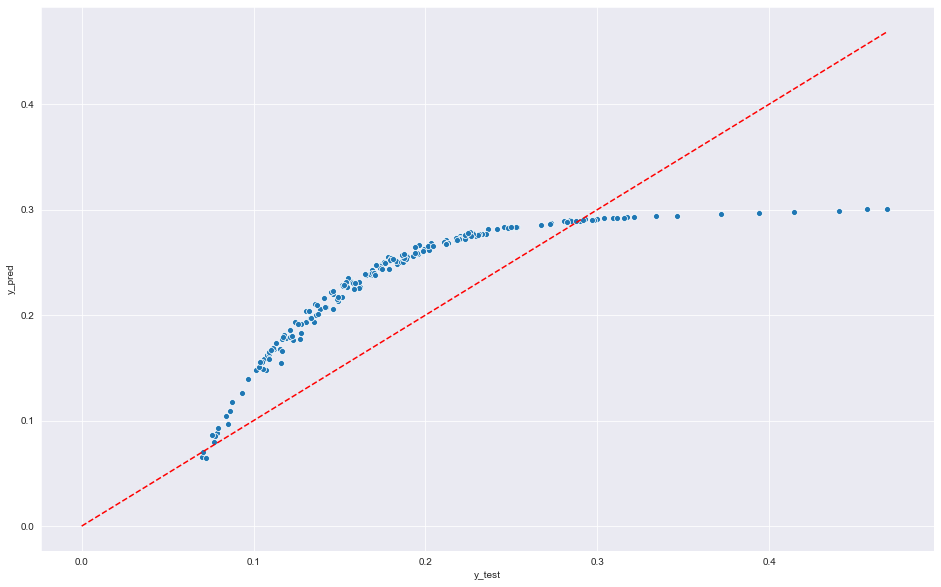

In [368]:
LSTMregression(X_train, X_test, y_train, y_test,
                 hidden_layer = 16,
                 batch_size = 16,
                 iterations = 5,
                 lr=0.005)

<h4  align="center"> Parameter choosing for LSTM
<h5 align="center">Table: Multi-Data scale results (lr = 0.01, epoch = 5)</h5> 

Data setting   | Pearson's R |MSE 
---------------| ----| -----------
Scale-1|nan|nan
Scale-10|-0.294217|20.048038
Scale-100|0.638529|0.200795
Scale-1000|0.882022|0.000153 
Log + Scale-1+ 1e-4|nan|nan 
Log + Scale-10+ 1e-4|nan|nan 
Log + Scale-100+ 1e-4|nan|nan 
Log + Scale-1000+ 1e-4|nan|nan  



<h5 align="center">Table: Multi-Learning Rate results  (epoch = 5)</h5> 

Learn Rate  |MSE | Pearson's R
-----------| ----| -----------
    5e-5 |0.000813|0.880952
    0.0005|0.000163|0.879562
 0.001|0.000162|0.884455
 0.005|0.000167|0.885032
 0.008| 0.000167|0.874162
 0.01|0.000164|0.872887
 0.02|0.000170|0.886134
 0.05|0.000344|0.850249
    0.1|0.000254|0.877462
    0.5|nan|nan

<h5 align="center">Table: Multi-Epoch results  (lr = 0.005)</h5> 

Epoch |MSE | Pearson's R 
-----------| ----| -----------
 1|0.000683|0.875354
 2|0.000201|0.886276
 5|0.000158|0.884628
 10|0.000158|0.878438
 20|0.000245|0.813084
 50|0.000169|0.870137
 100|0.000170|0.870863

<h5 align="center">Table: Multi-Batch results(lr = 0.005,epoch=5)</h5> 

Batch  |MSE | Pearson's R
-----------| ----| -----------
1|0.000155|0.880654
2|0.000161|0.883163
4|0.000176|0.885560
8|0.000165|0.883144
16|0.000165|0.885320
25|0.000171|0.873660
    50|0.000164|0.875233
    100|0.000181|0.872243
    


<h5 align="center">Table: Multi-Hidden layer results (lr = 0.005,epoch=500,batch=16)</h5> 

Hidden layer number|MSE | Pearson's R 
-----------| ----| -----------
1|0.000209|0.882898
2|0.000183|0.881288
4|0.000162|0.884207
8|0.000152|0.885214
16|0.000239|0.874001
    32|0.000232|0.884557
    64|nan|nan

## Resource for generating AutoRegressive (AR) data and LSTM example

In [1]:
#https://github.com/jessicayung/blog-code-snippets/blob/master/lstm-pytorch/lstm-baseline.py
#https://github.com/jessicayung/blog-code-snippets/blob/master/lstm-pytorch/generate_data.py

In [ ]:
# """
# Code to generate autoregressive data.
# Blog post: http://www.jessicayung.com/generating-autoregressive-data-for-experiments=
# Author: Jessiac Yung
# Sept 2018
# """
# import numpy as np
# from sklearn.model_selection import train_test_split

# class TimeSeriesData:
#     def __init__(self, num_datapoints, test_size=0.2, max_t=20, num_prev=1,
#                  noise_var=1):
#         """
#         Template class for generating time series data.
#         :param test_size: in (0,1), data to be used in test set as a fraction of all data generated.
#         """
#         self.num_datapoints = num_datapoints
#         self.test_size = test_size
#         self.num_prev = num_prev
#         self.max_t = max_t
#         self.data = None
#         self.noise_var = noise_var
#         self.y = np.zeros(num_datapoints + num_prev*4) # TODO: check this
#         self.bayes_preds = np.copy(self.y)

#         # Generate data and reshape data
#         self.create_data()

#         # Split into training and test sets
#         self.train_test_split()

#     def create_data(self):
#         self.generate_data()
#         self.reshape_data()

#     def generate_data(self):
#         """Generates data in self.y, may take as implicit input timesteps self.t.
#         May also generate Bayes predictions."""
#         raise NotImplementedError("Generate data method not implemented.")

#     def reshape_data(self):
#         self.x = np.reshape([self.y[i:i + self.num_prev] for i in range(
#             self.num_datapoints)], (-1, self.num_prev))
#         self.y = np.copy(self.y[self.num_prev:])
#         self.bayes_preds = np.copy(self.bayes_preds[self.num_prev:])

#     def train_test_split(self):
#         test_size = int(len(self.y) * self.test_size)
#         self.data = [self.X_train, self.X_test, self.y_train,
#                      self.y_test] = \
#                     self.x[:-test_size], self.x[-test_size:], \
#                     self.y[:-test_size], self.y[-test_size:]
#         self.bayes_preds = [self.bayes_train_preds, self.bayes_test_preds] = self.bayes_preds[:-test_size], self.bayes_preds[-test_size:]

#     def return_data(self):
#         return self.data

#     def return_train_test(self):
#         return self.X_train, self.y_train, self.X_test, self.y_test

# class ARData(TimeSeriesData):
#     """Class to generate autoregressive data."""

#     def __init__(self, *args, coeffs=None, **kwargs):
#         self.given_coeffs = coeffs
#         super(ARData, self).__init__(*args, **kwargs)

#         if coeffs is not None:
#             self.num_prev = len(coeffs) - 1

#     def generate_data(self):
#         self.generate_coefficients()
#         self.generate_initial_points()

#         # + 3*self.num_prev because we want to cut first (3*self.num_prev) datapoints later
#         # so dist is more stationary (else initial num_prev datapoints will stand out as diff dist)
#         for i in range(self.num_datapoints+3*self.num_prev):
#             # Generate y value if there was no noise
#             # (equivalent to Bayes predictions: predictions from oracle that knows true parameters (coefficients))
#             self.bayes_preds[i + self.num_prev] = np.dot(self.y[i:self.num_prev+i][::-1], self.coeffs)
#             # Add noise
#             self.y[i + self.num_prev] = self.bayes_preds[i + self.num_prev] + self.noise()

#         # Cut first 20 points so dist is roughly stationary
#         self.bayes_preds = self.bayes_preds[3*self.num_prev:]
#         self.y = self.y[3*self.num_prev:]

#     def generate_coefficients(self):
#         if self.given_coeffs is not None:
#             self.coeffs = self.given_coeffs
#         else:
#             filter_stable = False
#             # Keep generating coefficients until we come across a set of coefficients
#             # that correspond to stable poles
#             while not filter_stable:
#                 true_theta = np.random.random(self.num_prev) - 0.5
#                 coefficients = np.append(1, -true_theta)
#                 # check if magnitude of all poles is less than one
#                 if np.max(np.abs(np.roots(coefficients))) < 1:
#                     filter_stable = True
#             self.coeffs = true_theta

#     def generate_initial_points(self):
#         # Initial datapoints distributed as N(0,1)
#         self.y[:self.num_prev] = np.random.randn(self.num_prev)

#     def noise(self):
#         # Noise distributed as N(0, self.noise_var)
#         return self.noise_var * np.random.randn()

# # A set of coefficients that are stable (to produce replicable plots, experiments)
# fixed_ar_coefficients = {2: [ 0.46152873, -0.29890739],
#     5: [ 0.02519834, -0.24396899,  0.2785921,   0.14682383,  0.39390468],
#                         10: [-0.10958935, -0.34564819,  0.3682048,   0.3134046,  -0.21553732,  0.34613629,
#   0.41916508,  0.0165352,   0.14163503, -0.38844378],
#                          20: [ 0.1937815,   0.01201026,  0.00464018, -0.21887467, -0.20113385, -0.02322278,
#   0.34285319, -0.21069086,  0.06604683, -0.22377364,  0.11714593, -0.07122126,
#  -0.16346554,  0.03174824,  0.308584,    0.06881604,  0.24840789, -0.32735569,
#   0.21939492, 0.3996207 ]}

# """
# Example of using fixed coefficients (consistency across tests of different models)
# data = ARData(100, coeffs=fixed_ar_coefficients[5], num_prev=5)
# plt.plot(data.y_train)
# """

In [ ]:
# import torch
# import torch.nn as nn
# from generate_data import *
# import matplotlib.pyplot as plt

# #####################
# # Set parameters
# #####################

# # Data params
# noise_var = 0
# num_datapoints = 100
# test_size = 0.2
# num_train = int((1-test_size) * num_datapoints)

# # Network params
# input_size = 20
# # If `per_element` is True, then LSTM reads in one timestep at a time.
# per_element = True
# if per_element:
#     lstm_input_size = 1
# else:
#     lstm_input_size = input_size
# # size of hidden layers
# h1 = 32
# output_dim = 1
# num_layers = 2
# learning_rate = 1e-3
# num_epochs = 500
# dtype = torch.float

# #####################
# # Generate data
# #####################
# data = ARData(num_datapoints, num_prev=input_size, test_size=test_size, noise_var=noise_var, coeffs=fixed_ar_coefficients[input_size])

# # make training and test sets in torch
# X_train = torch.from_numpy(data.X_train).type(torch.Tensor)
# X_test = torch.from_numpy(data.X_test).type(torch.Tensor)
# y_train = torch.from_numpy(data.y_train).type(torch.Tensor).view(-1)
# y_test = torch.from_numpy(data.y_test).type(torch.Tensor).view(-1)

# X_train = X_train.view([input_size, -1, 1])
# X_test = X_test.view([input_size, -1, 1])

# #####################
# # Build model
# #####################

# # Here we define our model as a class
# class LSTM(nn.Module):

#     def __init__(self, input_dim, hidden_dim, batch_size, output_dim=1,
#                     num_layers=2):
#         super(LSTM, self).__init__()
#         self.input_dim = input_dim
#         self.hidden_dim = hidden_dim
#         self.batch_size = batch_size
#         self.num_layers = num_layers

#         # Define the LSTM layer
#         self.lstm = nn.LSTM(self.input_dim, self.hidden_dim, self.num_layers)

#         # Define the output layer
#         self.linear = nn.Linear(self.hidden_dim, output_dim)

#     def init_hidden(self):
#         # This is what we'll initialise our hidden state as
#         return (torch.zeros(self.num_layers, self.batch_size, self.hidden_dim),
#                 torch.zeros(self.num_layers, self.batch_size, self.hidden_dim))

#     def forward(self, input):
#         # Forward pass through LSTM layer
#         # shape of lstm_out: [input_size, batch_size, hidden_dim]
#         # shape of self.hidden: (a, b), where a and b both 
#         # have shape (num_layers, batch_size, hidden_dim).
#         lstm_out, self.hidden = self.lstm(input.view(len(input), self.batch_size, -1))
        
#         # Only take the output from the final timetep
#         # Can pass on the entirety of lstm_out to the next layer if it is a seq2seq prediction
#         y_pred = self.linear(lstm_out[-1].view(self.batch_size, -1))
#         return y_pred.view(-1)

# model = LSTM(lstm_input_size, h1, batch_size=num_train, output_dim=output_dim, num_layers=num_layers)

# loss_fn = torch.nn.MSELoss(size_average=False)

# optimiser = torch.optim.Adam(model.parameters(), lr=learning_rate)

# #####################
# # Train model
# #####################

# hist = np.zeros(num_epochs)

# for t in range(num_epochs):
#     # Initialise hidden state
#     # Don't do this if you want your LSTM to be stateful
#     model.hidden = model.init_hidden()
    
#     # Forward pass
#     y_pred = model(X_train)

#     loss = loss_fn(y_pred, y_train)
#     if t % 100 == 0:
#         print("Epoch ", t, "MSE: ", loss.item())
#     hist[t] = loss.item()

#     # Zero out gradient, else they will accumulate between epochs
#     optimiser.zero_grad()

#     # Backward pass
#     loss.backward()

#     # Update parameters
#     optimiser.step()

# #####################
# # Plot preds and performance
# #####################

# plt.plot(y_pred.detach().numpy(), label="Preds")
# plt.plot(y_train.detach().numpy(), label="Data")
# plt.legend()
# plt.show()

# plt.plot(hist, label="Training loss")
# plt.legend()
# plt.show()